In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import optuna
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable to the DataFrame
df['target'] = data.target

# Creating a reduced dataset without the "error" variables
error_columns = [col for col in df.columns if 'error' in col]
df_reduced = df.drop(columns=error_columns)

# Creating a reduced dataset without the "area" and "perimeter" variables
cols_to_drop = ["mean perimeter", "mean area", "worst perimeter", "worst area"]
df_reduced = df_reduced.drop(columns=cols_to_drop)


In [3]:
# Instantiating Scaler
scaler = StandardScaler()

# Standardizing data from reduced dataset
X = df_reduced.drop(columns="target").values
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95, random_state=42)  # Retain components that explain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Checking the number of principal components retained and the explained variance
num_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()

# Converting num_components to int
num_components = int(num_components)

# Convering explained_variance to percentage
explained_variance = explained_variance * 100

print(f"Number of principal components retained: {num_components}")

print(f"Explained variance: {explained_variance:.2f}")

Number of principal components retained: 7
Explained variance: 96.30


In [4]:
# Splitting the PCA-transformed data into training and test sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, df_reduced["target"].values, test_size=0.25, random_state=42)

# Performing LASSO regression with cross-validation on the PCA-transformed data
lasso_pca = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso_pca.fit(X_train_pca, y_train)

# Predicting on the test set
y_pred_pca = lasso_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)

# Extracting the coefficients for the principal components
lasso_coefficients_pca = pd.DataFrame({
    "Principal Component": ["PC" + str(i+1) for i in range(num_components)], 
    "Coefficient": lasso_pca.coef_
})

# Convert mse to float
mse_pca = float(mse_pca)

print(mse_pca)
print(lasso_coefficients_pca)

0.06149017584584747
  Principal Component  Coefficient
0                 PC1    -0.125394
1                 PC2     0.103608
2                 PC3    -0.000000
3                 PC4    -0.037703
4                 PC5    -0.018162
5                 PC6    -0.062660
6                 PC7     0.003617


([<matplotlib.axis.XTick at 0x1d474c35fa0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

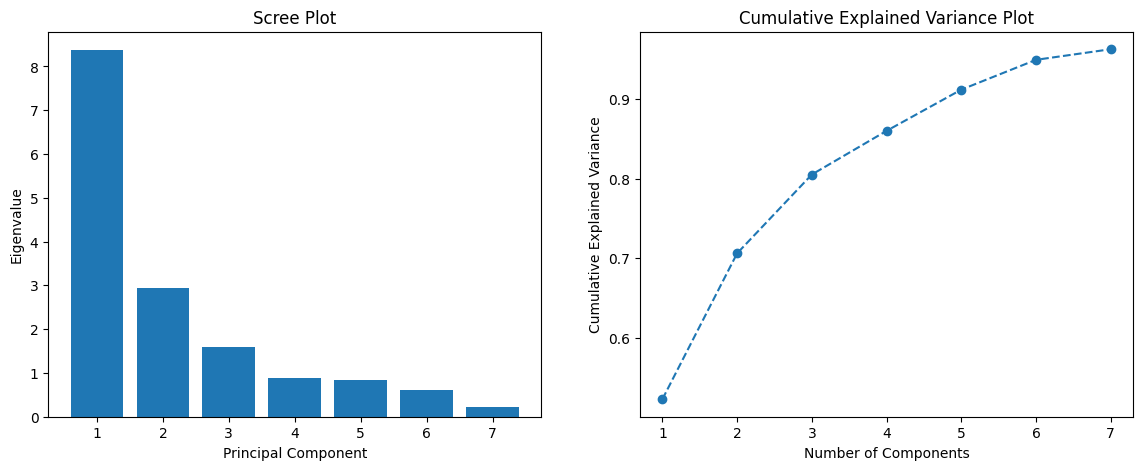

In [5]:
# Extracting eigenvalues (variance explained by each component)
eigenvalues = pca.explained_variance_

# Calculating cumulative explained variance again
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting Scree Plot and Cumulative Explained Variance Plot
plt.figure(figsize=(14, 5))

# Subplot 1: Scree plot
plt.subplot(1, 2, 1)
plt.bar(range(1, len(eigenvalues)+1), eigenvalues)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.xticks(range(1, len(eigenvalues)+1))

# Subplot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(eigenvalues)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.xticks(range(1, len(eigenvalues)+1))

In [6]:
# Getting the principal components (loadings)
loadings = pca.components_

# Creating a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=df_reduced.columns[:-1], 
                           index=["PC" + str(i+1) for i in range(loadings.shape[0])])

loadings_df

,mean radius,mean texture,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,worst radius,worst texture,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
PC1,0.210402,0.119592,0.227420,0.322933,0.315367,0.306153,0.212269,0.151287,0.229885,0.140523,0.230421,0.308697,0.311764,0.318156,0.216380,0.240977
PC2,-0.413631,-0.271641,0.249184,0.068323,-0.089812,-0.177252,0.210121,0.456624,-0.385783,-0.229474,0.232057,0.067305,-0.025110,-0.137268,0.165212,0.299305
PC3,-0.234179,0.601762,-0.148911,-0.066484,-0.114624,-0.203020,-0.038101,0.093436,-0.183078,0.626276,0.038792,0.095338,0.030150,-0.106451,0.093770,0.185857
PC4,0.040842,0.040749,0.110885,-0.129365,-0.141652,-0.007244,0.608475,-0.238981,0.061687,0.080713,0.060131,-0.186750,-0.209146,-0.041238,0.580248,-0.298711
PC5,0.027729,0.158575,0.591243,-0.031915,-0.047087,0.119849,-0.122863,0.037611,0.038979,0.157813,0.502537,-0.279702,-0.245576,-0.022246,-0.361920,-0.203515
PC6,0.005705,-0.252151,-0.030611,-0.255345,-0.272159,-0.176010,-0.418689,-0.355631,0.105499,0.029885,0.491771,0.192198,0.120113,0.170749,0.322540,0.158142
PC7,-0.314280,-0.023722,0.018103,-0.123794,0.384645,-0.007570,0.091744,-0.303211,-0.392112,0.013459,0.125529,-0.045486,0.554980,0.080864,-0.108275,-0.372324


In [7]:
# Creating the equations for each principal component based on the loadings
pc_equations = {}

for i, pc in enumerate(loadings_df.index):
    equation = " + ".join(f"{loadings_df.iloc[i, j]:.4f} × {col}" for j, col in enumerate(loadings_df.columns))
    pc_equations[pc] = equation

pc_equations


{'PC1': '0.2104 × mean radius + 0.1196 × mean texture + 0.2274 × mean smoothness + 0.3229 × mean compactness + 0.3154 × mean concavity + 0.3062 × mean concave points + 0.2123 × mean symmetry + 0.1513 × mean fractal dimension + 0.2299 × worst radius + 0.1405 × worst texture + 0.2304 × worst smoothness + 0.3087 × worst compactness + 0.3118 × worst concavity + 0.3182 × worst concave points + 0.2164 × worst symmetry + 0.2410 × worst fractal dimension',
 'PC2': '-0.4136 × mean radius + -0.2716 × mean texture + 0.2492 × mean smoothness + 0.0683 × mean compactness + -0.0898 × mean concavity + -0.1773 × mean concave points + 0.2101 × mean symmetry + 0.4566 × mean fractal dimension + -0.3858 × worst radius + -0.2295 × worst texture + 0.2321 × worst smoothness + 0.0673 × worst compactness + -0.0251 × worst concavity + -0.1373 × worst concave points + 0.1652 × worst symmetry + 0.2993 × worst fractal dimension',
 'PC3': '-0.2342 × mean radius + 0.6018 × mean texture + -0.1489 × mean smoothness + -

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 1e-6, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 10000)
    
    # Ensure valid combination of solver and penalty
    if solver == 'lbfgs' and penalty not in ['l2', 'none']:
        raise optuna.exceptions.TrialPruned()
    if solver in ['newton-cg', 'sag', 'saga'] and penalty not in ['l2', 'none']:
        raise optuna.exceptions.TrialPruned()
    if solver == 'liblinear' and penalty not in ['l1', 'l2']:
        raise optuna.exceptions.TrialPruned()
    
    # Initialize the logistic regression model with trial hyperparameters
    logistic_model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter, random_state=42)
    
    # Train the model
    logistic_model.fit(X_train_pca, y_train)
    
    # Predict on the test set
    y_pred = logistic_model.predict(X_test_pca)
    
    # Calculate F1 macro score
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    return f1_macro

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the logistic regression model using the best hyperparameters from Optuna
logistic_model = LogisticRegression(**best_params, random_state=42)
logistic_model.fit(X_train_pca, y_train)

# Predict using the optimized model
y_pred = logistic_model.predict(X_test_pca)


[I 2024-09-30 11:32:22,318] A new study created in memory with name: no-name-1e47c929-9487-44e7-96fe-c33d7f856fd9
[I 2024-09-30 11:32:22,319] Trial 0 pruned. 
[I 2024-09-30 11:32:22,325] Trial 1 finished with value: 0.9704545454545455 and parameters: {'C': 8.037856019730725, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 7957}. Best is trial 1 with value: 0.9704545454545455.
[I 2024-09-30 11:32:22,326] Trial 2 pruned. 
[I 2024-09-30 11:32:22,327] Trial 3 pruned. 
[I 2024-09-30 11:32:22,330] Trial 4 finished with value: 0.948795334799734 and parameters: {'C': 2.258423417655707e-06, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 4045}. Best is trial 1 with value: 0.9704545454545455.
[I 2024-09-30 11:32:22,331] Trial 5 pruned. 
[I 2024-09-30 11:32:22,334] Trial 6 finished with value: 0.9626690335717643 and parameters: {'C': 0.019958493915887703, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 7782}. Best is trial 1 with value: 0.9704545454545455.
[I 2024-09-30 11:32:22,339] Trial 7 

Best hyperparameters: {'C': 0.13878168729169457, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 6815}


In [9]:
print(classification_report(y_test, y_pred))

print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.99      0.99      0.99        89

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143

F1 Score: 0.9851227632126509


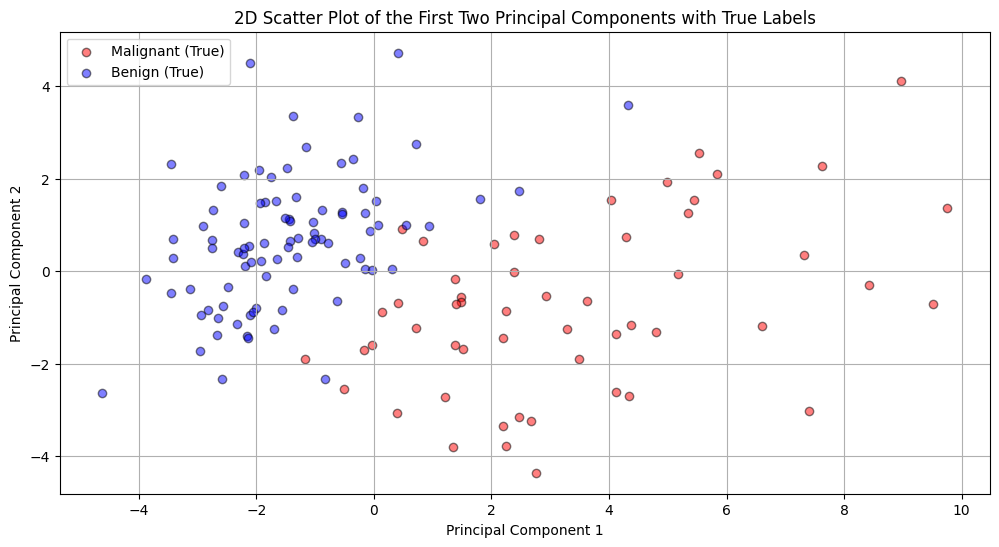

In [10]:
#2D Scatter Plot of the first two Principal Components
plt.figure(figsize=(12, 6))

# Plotting the true labels
plt.scatter(X_test_pca[y_test==0, 0], X_test_pca[y_test==0, 1], color='red', label='Malignant (True)', alpha=0.5, edgecolor='k')
plt.scatter(X_test_pca[y_test==1, 0], X_test_pca[y_test==1, 1], color='blue', label='Benign (True)', alpha=0.5, edgecolor='k')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('2D Scatter Plot of the First Two Principal Components with True Labels')
plt.grid(True)
plt.show()


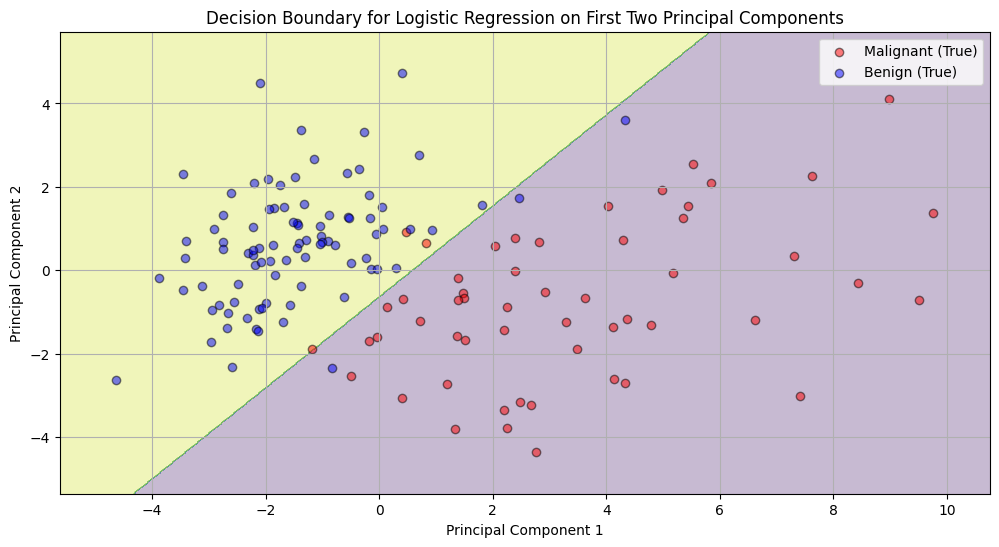

In [11]:
# 2. Decision Boundary Visualization for the first two principal components

# Creating a grid to evaluate the model
h = .02  # step size in the mesh
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Training the logistic regression model using only the first two principal components
logistic_model_2D = LogisticRegression(**best_params, random_state=42)
logistic_model_2D.fit(X_train_pca[:, :2], y_train)

# Predicting over the grid
Z = logistic_model_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting the decision boundary
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test_pca[y_test==0, 0], X_test_pca[y_test==0, 1], color='red', label='Malignant (True)', edgecolor='k', alpha=0.5)
plt.scatter(X_test_pca[y_test==1, 0], X_test_pca[y_test==1, 1], color='blue', label='Benign (True)', edgecolor='k', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('Decision Boundary for Logistic Regression on First Two Principal Components')
plt.grid(True)
plt.show()


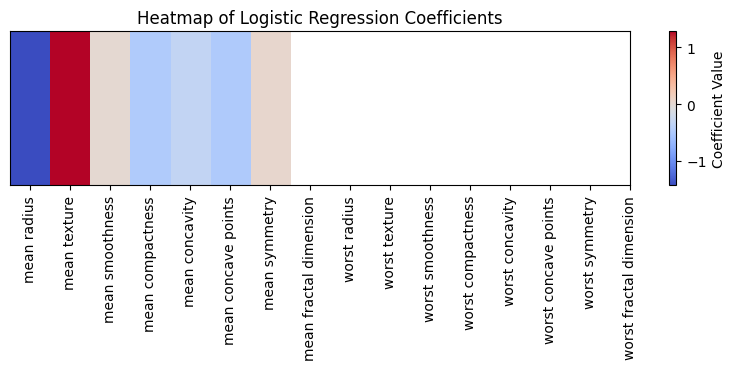

In [12]:
# 3. Heatmap of Coefficients

# Extracting coefficients from the logistic model
coefficients = logistic_model.coef_

# Plotting the heatmap
plt.figure(figsize=(10, 2))
plt.imshow(coefficients, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Coefficient Value')
plt.yticks([])
plt.xticks(range(len(loadings_df.columns)), loadings_df.columns, rotation=90)
plt.title('Heatmap of Logistic Regression Coefficients')
plt.show()


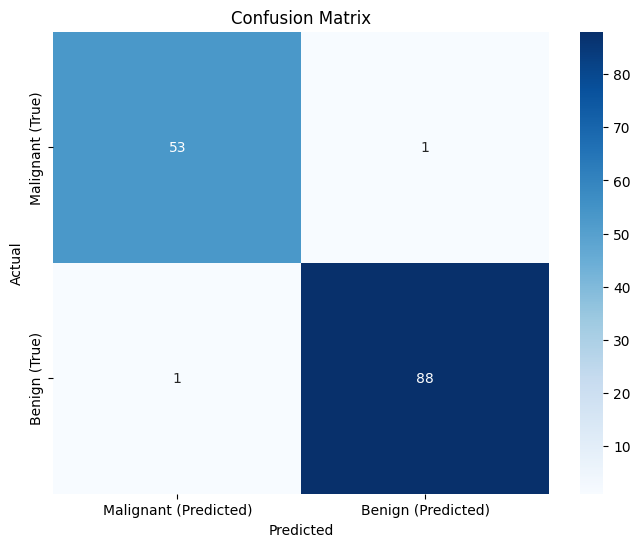

In [13]:
# 4. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant (Predicted)', 'Benign (Predicted)'], 
            yticklabels=['Malignant (True)', 'Benign (True)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
